## Load in data

In [1]:
%load_ext autoreload
%autoreload 2
from ais_dataloader import *
import ipywidgets as widgets
from IPython.display import display


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [2]:
date_range = pd.date_range(start='2024-01-01', end='2024-01-01', freq='D')
gp_regression_dataset = AISTrajectoryRegressionDataset(date_range, device)


Combining AIS CSVs into a single df: 100%|██████████| 1/1 [00:07<00:00,  7.67s/it]


Processing AIS data...
Removed 5167987 out of 7296275 rows due to invalid COG, SOG, LAT, or Heading values.


## Fit GP Models

In [ ]:
import torch
import gpytorch
from multioutput_gp import *

num_trajectories = 1
models = []
likelihoods = []
losses = []

for idx in range(num_trajectories):
    mmsi, times, state_trajectory = gp_regression_dataset[idx]
    X = torch.tensor(times, dtype=torch.float32).unsqueeze(1).to(device)
    Y = torch.tensor(state_trajectory, dtype=torch.float32).to(device)
    num_outputs = Y.shape[1]

    print(num_outputs)
    
    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_outputs, noise_prior=gpytorch.priors.NormalPrior(loc=0.5, scale=5.0)).to(device)
    model = MultiOutputExactGPModel(X, Y, likelihood, num_outputs=num_outputs).to(device)

    loss, model, likelihood = train_model(model, likelihood, X, Y, num_epochs=1000, lr=0.01)

    models.append(model)
    likelihoods.append(likelihood)
    losses.append(loss.item())

/var/folders/vw/3pp1qrb97m97jj_776599z6c0000gn/T/ipykernel_17633/2659715812.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(times, dtype=torch.float32).unsqueeze(1).to(device)
/var/folders/vw/3pp1qrb97m97jj_776599z6c0000gn/T/ipykernel_17633/2659715812.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y = torch.tensor(state_trajectory, dtype=torch.float32).to(device)


6


GP Training Progress: 100%|██████████| 1000/1000 [00:03<00:00, 289.66it/s]


[0.6931471824645996]
OrderedDict({'task_covar_module.covar_factor': tensor([[ 4.7498e+00],
        [-1.8339e+00],
        [-2.1737e-07],
        [ 3.4847e-07],
        [ 2.7273e-08],
        [-4.4579e-07]]), 'task_covar_module.raw_var': tensor([ 1.7434,  0.6721,  1.7514, -0.2350, -0.3210,  1.0822]), 'task_covar_module.raw_var_constraint.lower_bound': tensor(0.), 'task_covar_module.raw_var_constraint.upper_bound': tensor(inf), 'data_covar_module.raw_lengthscale': tensor([[0.]]), 'data_covar_module.raw_lengthscale_constraint.lower_bound': tensor(0.), 'data_covar_module.raw_lengthscale_constraint.upper_bound': tensor(inf)})


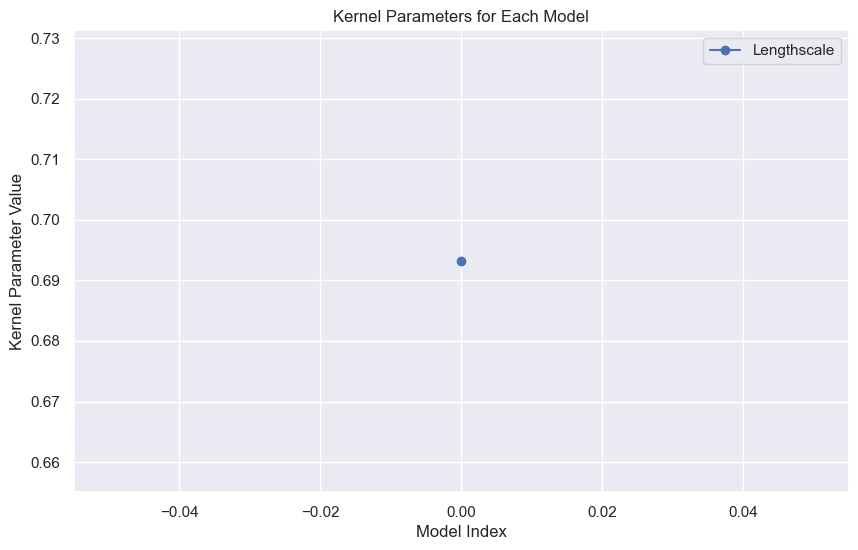

Parameter name: likelihood.raw_task_noises                 value = [2.0211565494537354, 0.43809258937835693, 0.30980396270751953, 0.4540541172027588, 0.16669298708438873, 0.5659784078598022]
Parameter name: likelihood.raw_noise                       value = [1.9783644676208496]
Parameter name: mean_module.base_means.0.raw_constant      value = [-4.52386474609375]
Parameter name: mean_module.base_means.1.raw_constant      value = [0.6019338369369507]
Parameter name: mean_module.base_means.2.raw_constant      value = [-0.3609559237957001]
Parameter name: mean_module.base_means.3.raw_constant      value = [0.5849985480308533]
Parameter name: mean_module.base_means.4.raw_constant      value = [0.04518372192978859]
Parameter name: mean_module.base_means.5.raw_constant      value = [-0.7465994358062744]
Parameter name: covar_module.task_covar_module.covar_factor value = [4.7497711181640625, -1.8339447975158691, -2.1737085376116738e-07, 3.484716160073731e-07, 2.727286485537661e-08, -4.4579041

In [11]:
import matplotlib.pyplot as plt

# Extract kernel parameters (e.g., lengthscale) for each model
lengthscales = [
    model.covar_module.data_covar_module.lengthscale.item() for model in models
]
# Extract covariance parameters (e.g., outputscale) for each model
print(lengthscales)


print(model.covar_module.state_dict())

# Plot the kernel parameters
plt.figure(figsize=(10, 6))
plt.plot(range(len(models)), lengthscales, marker='o', label='Lengthscale')
plt.xlabel('Model Index')
plt.ylabel('Kernel Parameter Value')
plt.title('Kernel Parameters for Each Model')
plt.legend()
plt.grid(True)
plt.show()



for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.flatten().tolist()}')

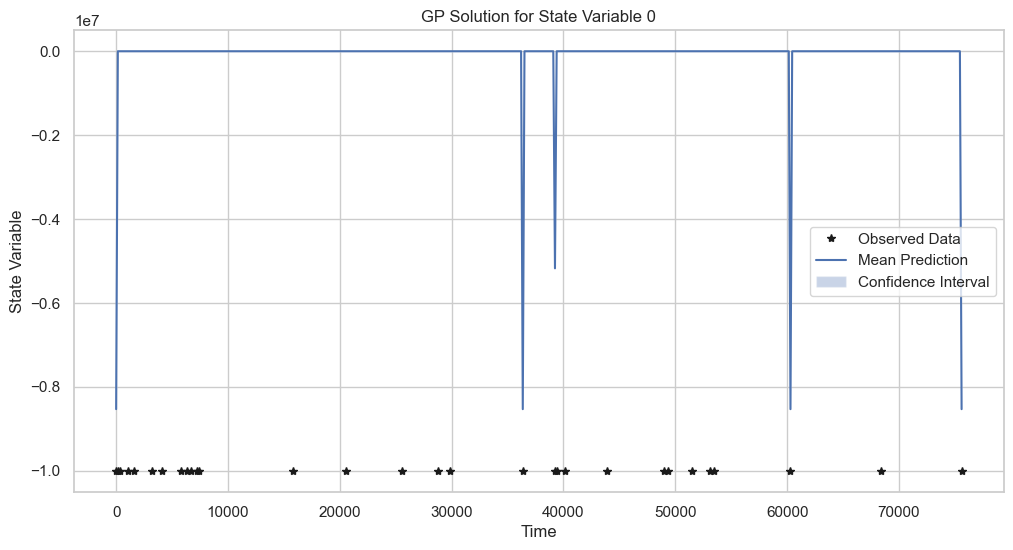

In [5]:
# Set the model and likelihood to evaluation mode
model.eval()
likelihood.eval()

# Generate test inputs (e.g., evenly spaced time points)
test_times = torch.linspace(times.min(), times.max(), 500).unsqueeze(1).to(device)

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = likelihood(model(test_times))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(times.cpu(), state_trajectory[:, 0].cpu(), 'k*', label='Observed Data')
plt.plot(test_times.cpu(), mean[:, 0].cpu(), 'b', label='Mean Prediction')
plt.fill_between(
    test_times.cpu().squeeze(),
    lower[:, 0].cpu(),
    upper[:, 0].cpu(),
    alpha=0.3,
    label='Confidence Interval'
)
plt.xlabel('Time')
plt.ylabel('State Variable')
plt.title('GP Solution for State Variable 0')
plt.legend()
plt.grid(True)
plt.show()

### Plot GP Solution

In [6]:
# train_x ~ times
# train_y ~ state_trajectory

# test_X ~ times

## Plotting


torch.Size([990])

torch.Size([990, 6])

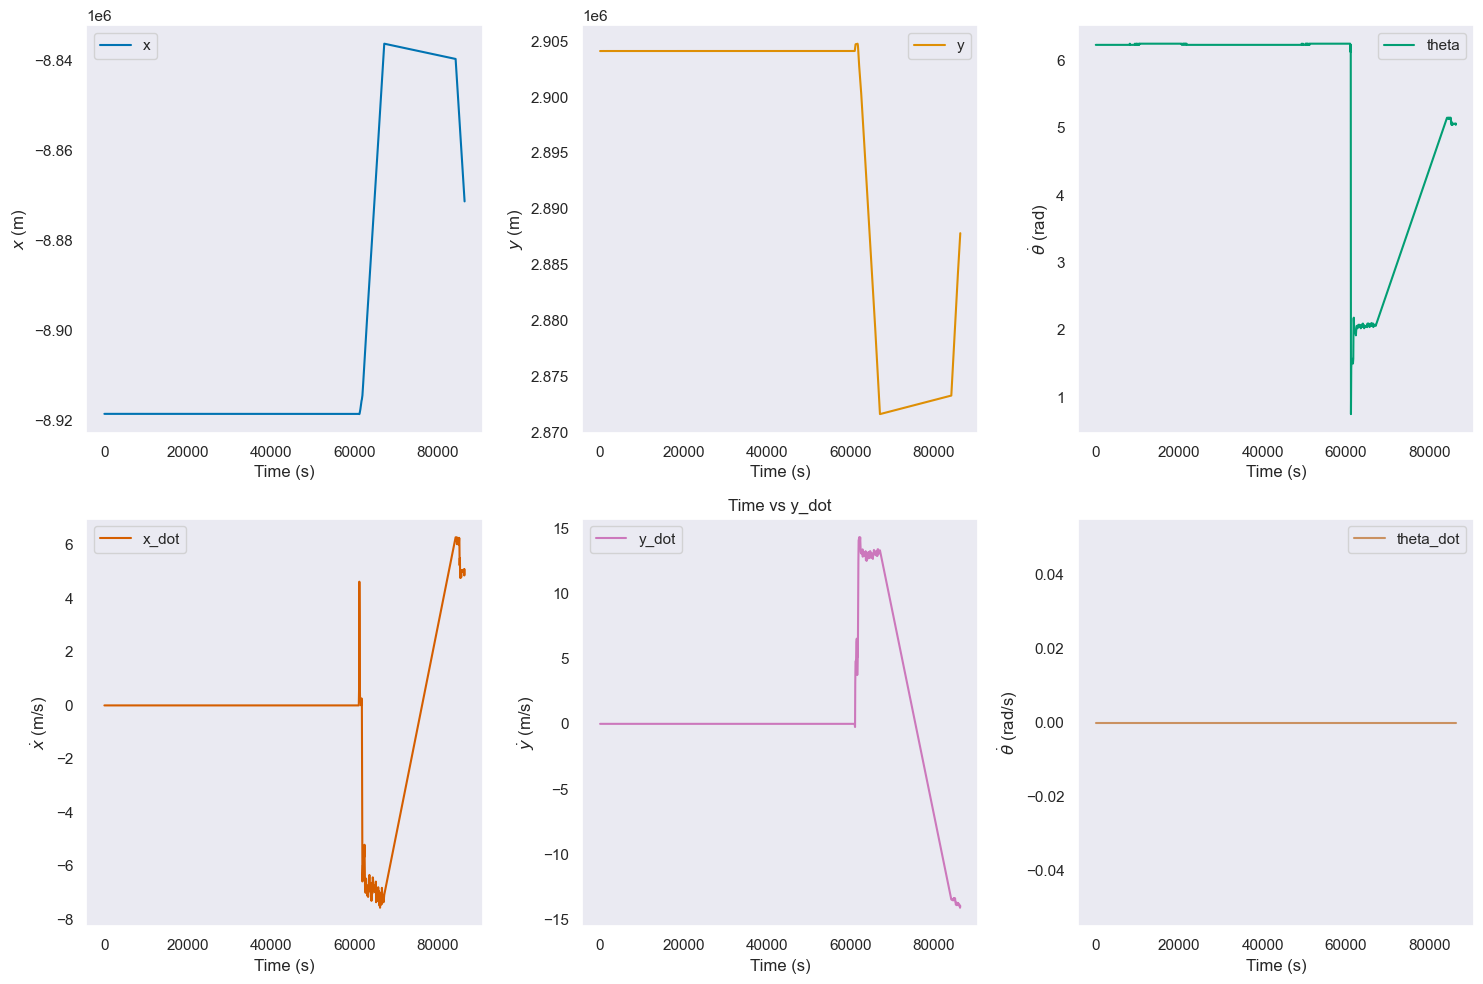

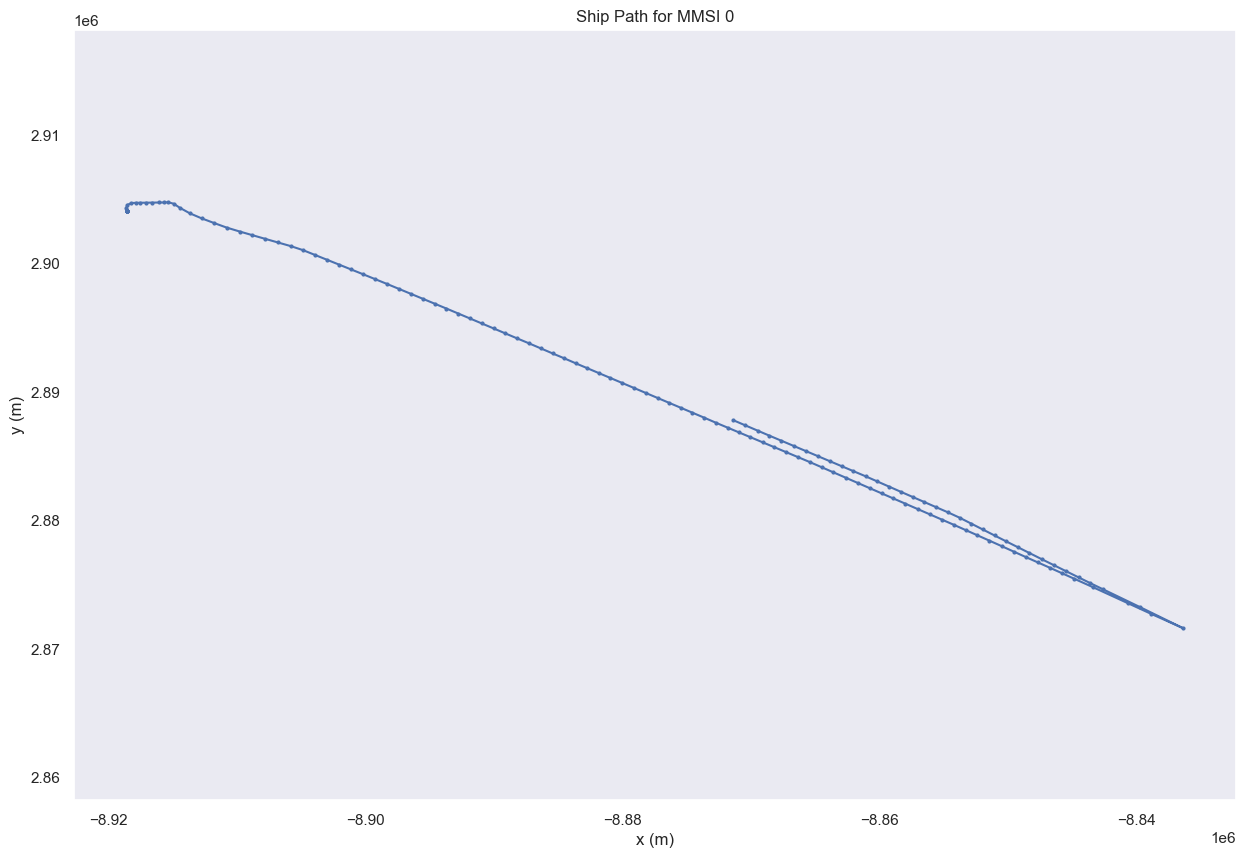

In [7]:
mmsi, times, state_trajectory = gp_regression_dataset[10]

display(times.shape, state_trajectory.shape)
from plotting_utils import *

plot_single_ship_state_trajectory(0, times, state_trajectory)
plot_single_ship_path(0, times, state_trajectory)